In [1]:
!pip install tensorflow==2.11.0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install git+https://github.com/VenkateshwaranB/stellargraph.git

  Cloning https://github.com/VenkateshwaranB/stellargraph.git to /tmp/pip-req-build-1nx6zykl
  Running command git clone --filter=blob:none --quiet https://github.com/VenkateshwaranB/stellargraph.git /tmp/pip-req-build-1nx6zykl
  Resolved https://github.com/VenkateshwaranB/stellargraph.git to commit ce29510c83d924561c9e6054641d02a5abdeaaf5
  Preparing metadata (setup.py) ... done
  Created wheel for stellargraph: filename=stellargraph-1.3.0b0-py3-none-any.whl size=431853 sha256=1d4052071936a2813925df25b6fb9c9d038562764360ef4f3e47d3e1b0777319
  Stored in directory: /tmp/pip-ephem-wheel-cache-ue2p13km/wheels/f3/06/0f/089f69af27d308a1830638f855b6c5755311d8ffc451de9980
Successfully built stellargraph


In [4]:
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

<div class="alert alert-block alert-danger">This notebook is designed for an older StellarGraph version 1.2.1 and may not function correctly with the newer installed version 1.3.0b. Please see: <a href="https://github.com/stellargraph/stellargraph/issues/1172">https://github.com/stellargraph/stellargraph/issues/1172</a>.</div>

<ipython-input-4-9f0eb37542e2>:4: DeprecationWarning: This notebook is designed for an older StellarGraph version 1.2.1 and may not function correctly with the newer installed version 1.3.0b. Please see: <https://github.com/stellargraph/stellargraph/issues/1172>.
  sg.utils.validate_notebook_version("1.2.1")


In [5]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

from stellargraph import datasets
from stellargraph.utils import plot_history

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [6]:
df_edges = pd.read_csv('/content/drive/MyDrive/graph_ISB_edges.csv', index_col=0)
df_edges

,source,target
0,0,0
1,0,1
2,0,2
3,0,17
4,0,19
...,...,...
153688,1103,1103
153689,1106,1106
153690,1109,1109
153691,1114,1114


In [7]:
node_features_df = pd.read_csv('/content/drive/MyDrive/node_features_hashtag_df.csv')
node_features_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.189092,-0.059448,0.036934,-0.163505,0.014944,-0.042785,0.065283,0.223801,-0.252894,-0.190002,...,0.072798,0.023225,0.068635,-0.076926,0.118267,-0.121892,-0.053214,-0.071568,0.132806,0.221732
1,-0.189092,-0.059448,0.036934,-0.163505,0.014944,-0.042785,0.065283,0.223801,-0.252894,-0.190002,...,0.072798,0.023225,0.068635,-0.076926,0.118267,-0.121892,-0.053214,-0.071568,0.132806,0.221732
2,-0.189092,-0.059448,0.036934,-0.163505,0.014944,-0.042785,0.065283,0.223801,-0.252894,-0.190002,...,0.072798,0.023225,0.068635,-0.076926,0.118267,-0.121892,-0.053214,-0.071568,0.132806,0.221732
3,-0.189092,-0.059448,0.036934,-0.163505,0.014944,-0.042785,0.065283,0.223801,-0.252894,-0.190002,...,0.072798,0.023225,0.068635,-0.076926,0.118267,-0.121892,-0.053214,-0.071568,0.132806,0.221732
4,-0.189092,-0.059448,0.036934,-0.163505,0.014944,-0.042785,0.065283,0.223801,-0.252894,-0.190002,...,0.072798,0.023225,0.068635,-0.076926,0.118267,-0.121892,-0.053214,-0.071568,0.132806,0.221732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,-0.189092,-0.059448,0.036934,-0.163505,0.014944,-0.042785,0.065283,0.223801,-0.252894,-0.190002,...,0.072798,0.023225,0.068635,-0.076926,0.118267,-0.121892,-0.053214,-0.071568,0.132806,0.221732
1226,-0.189092,-0.059448,0.036934,-0.163505,0.014944,-0.042785,0.065283,0.223801,-0.252894,-0.190002,...,0.072798,0.023225,0.068635,-0.076926,0.118267,-0.121892,-0.053214,-0.071568,0.132806,0.221732
1227,-0.189092,-0.059448,0.036934,-0.163505,0.014944,-0.042785,0.065283,0.223801,-0.252894,-0.190002,...,0.072798,0.023225,0.068635,-0.076926,0.118267,-0.121892,-0.053214,-0.071568,0.132806,0.221732
1228,-0.189092,-0.059448,0.036934,-0.163505,0.014944,-0.042785,0.065283,0.223801,-0.252894,-0.190002,...,0.072798,0.023225,0.068635,-0.076926,0.118267,-0.121892,-0.053214,-0.071568,0.132806,0.221732


In [8]:
G = StellarGraph(node_features_df, df_edges)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 1230, Edges: 153693

 Node types:
  default: [1230]
    Features: float32 vector, length 768
    Edge types: default-default->default

 Edge types:
    default-default->default: [153693]
        Weights: all 1 (default)
        Features: none


In [9]:
G.check_graph_for_ml(features=True)

In [10]:
df_final = pd.read_csv('/content/drive/MyDrive/final_data_ISB.csv')

node_event = {}
for index, row in df_final.iterrows():
    value = row['event']
    key = row['target_node']
    node_event[key] = value

    key = row['response_node']
    node_event[key] = value

In [11]:
import json

with open('/content/drive/MyDrive/reverse_tweet_user_index.json', 'r') as file:
    reverse_tweet_user_index = json.load(file)

print(reverse_tweet_user_index)

{'0': '53692193', '1': '1317129865', '2': '855007514621911040', '3': '878087280321335298', '4': '25073877', '5': '727264708776980480', '6': '3493563087', '7': '292929271', '8': '810619093749559296', '9': '17564591', '10': '26642006', '11': '38029205', '12': '807095', '13': '6473022', '14': '187428929', '15': '17261066', '16': '14247236', '17': '964032914626359296', '18': '149249831', '19': '27032207', '20': '21059255', '21': '246939630', '22': '19568591', '23': '469194846', '24': '21829541', '25': '983766825610694656', '26': '16041234', '27': '701725963', '28': '1917731', '29': '7702542', '30': '28785486', '31': '817382752731463680', '32': '1915033663', '33': '133938408', '34': '78515008', '35': '1589251639', '36': '32871086', '37': '958064770019741696', '38': '797229459803926528', '39': '18510860', '40': '132339474', '41': '24165761', '42': '1462969034', '43': '812135885328236551', '44': '817661098988019712', '45': '166751745', '46': '3260518932', '47': '15907183', '48': '755057897583

In [12]:
node_event

{321631653: 'Santa_Fe_Shooting',
 18655355: 'Santa_Fe_Shooting',
 2467720274: 'Santa_Fe_Shooting',
 3176702526: 'Santa_Fe_Shooting',
 24939978: 'Santa_Fe_Shooting',
 1646856415: 'Santa_Fe_Shooting',
 2932942216: 'Iran_Deal',
 766475610059317248: 'General_Terms',
 2909998207: 'General_Terms',
 59621769: 'General_Terms',
 15537302: 'General_Terms',
 908585996: 'General_Terms',
 17564591: 'Santa_Fe_Shooting',
 966354844754894848: 'Santa_Fe_Shooting',
 803694179079458816: 'Santa_Fe_Shooting',
 58007320: 'Student_Marches',
 2353605901: 'Student_Marches',
 117718572: 'General_Terms',
 875029068223315968: 'General_Terms',
 929766290323058688: 'General_Terms',
 35218566: 'Iran_Deal',
 2619593276: 'General_Terms',
 36711022: 'General_Terms',
 46756474: 'General_Terms',
 31059230: 'General_Terms',
 27194034: 'General_Terms',
 4124770811: 'Santa_Fe_Shooting',
 2964174789: 'Santa_Fe_Shooting',
 827641495125688321: 'Santa_Fe_Shooting',
 69176047: 'Santa_Fe_Shooting',
 956702734920564736: 'Santa_Fe_

In [13]:
graph_node_event = {}
for i in range(1230):
    node = reverse_tweet_user_index[str(i)]
    event = node_event[int(node)]
    graph_node_event[int(node)] = event

In [14]:
series = pd.Series(graph_node_event)
series.name = 'subject'
node_subjects = series
node_subjects

53692193              Santa_Fe_Shooting
1317129865              Student_Marches
855007514621911040    Santa_Fe_Shooting
878087280321335298    Santa_Fe_Shooting
25073877              Santa_Fe_Shooting
                            ...        
241280143                     Iran_Deal
907378373114163201    Santa_Fe_Shooting
21316253                Student_Marches
21117616                      Iran_Deal
973900707626672129            Iran_Deal
Name: subject, Length: 1230, dtype: object

In [15]:
fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)
gcn_model = GCN(layer_sizes=[128], activations=["relu"], generator=fullbatch_generator)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())

Using GCN (local pooling) filters...


In [16]:
infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))

In [17]:
epochs = 100

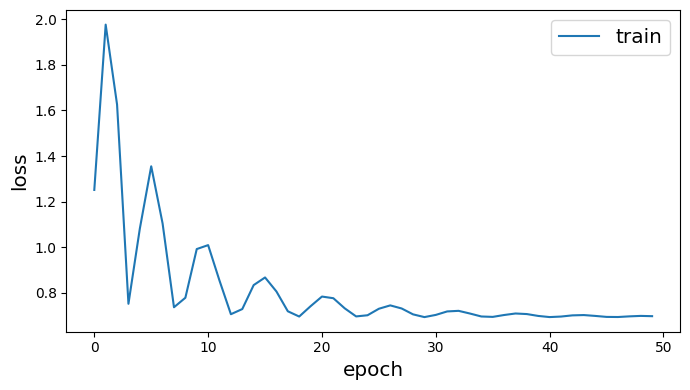

In [18]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
plot_history(history)

In [19]:
def get_node_embeddings (
    base_model, generator, epochs, reorder=lambda sequence, subjects: subjects
):
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes())
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    # for full batch models, squeeze out the batch dim (which is 1)
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

    return emb_model.predict(fullbatch_generator.flow(G.nodes()))

In [20]:
import numpy as np

cluster_generator = ClusterNodeGenerator(G, clusters=12, q=4)
cluster_gcn_model = GCN(
    layer_sizes=[128], activations=["relu"], generator=cluster_generator
)

def cluster_reorder(sequence, subjects):
    # shuffle the subjects into the same order as the sequence yield
    return subjects[sequence.node_order]

all_embeddings = get_node_embeddings(
    cluster_gcn_model, cluster_generator, epochs=epochs, reorder=cluster_reorder
)

print(type(all_embeddings))
np.shape(all_embeddings)

Number of clusters 12
0 cluster has size 102
1 cluster has size 102
2 cluster has size 102
3 cluster has size 102
4 cluster has size 102
5 cluster has size 102
6 cluster has size 102
7 cluster has size 102
8 cluster has size 102
9 cluster has size 102
10 cluster has size 102
11 cluster has size 108


1/1 [==============================] - 0s 174ms/step
<class 'numpy.ndarray'>


(1230, 128)

In [22]:
np.save('/content/drive/MyDrive/hashtag_node_embeddings_cluster_GCN.npy', all_embeddings)